In [390]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, Ord
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [401]:
import matplotlib.pylab as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] = (18.0, 8.0)
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
# %base16_mplrc dark solarized

The base16_mplrc extension is already loaded. To reload it, use:
  %reload_ext base16_mplrc


In [403]:
b16_colors

NameError: name 'b16_colors' is not defined

In [305]:
from sklearn.linear_model import LinearRegression

In [7]:
import cPickle as pickle
from fuzzywuzzy import fuzz, process
from fenaroli_parser.recipe_weights import compute_all_weights, match_ingredients, compute_single_avg_weight

In [8]:
from itertools import permutations, combinations
from fenaroli_parser.recipe_weights import compute_single_avg_weight, match_ingredients

In [219]:
from statsmodels.regression.linear_model import OLS

## comparing recipe weights to null model

In [41]:
with open('./comb_recipes.pkl', 'r') as f:
    comb_rec = pickle.load(f)

In [9]:
with open('./new_avg_recipe_weights.pkl', 'r') as f:
    avg_recipe = pickle.load(f)
with open('./new_avg_random_weights.pkl', 'r') as f:
    avg_random = pickle.load(f)

In [10]:
sorted(avg_recipe.values(), reverse = True)[:20]

sorted(avg_random.values(), reverse = True)[:20]

[178.0,
 178.0,
 177.0,
 177.0,
 177.0,
 177.0,
 177.0,
 177.0,
 170.0,
 170.0,
 161.0,
 161.0,
 161.0,
 161.0,
 161.0,
 161.0,
 155.0,
 155.0,
 155.0,
 155.0]

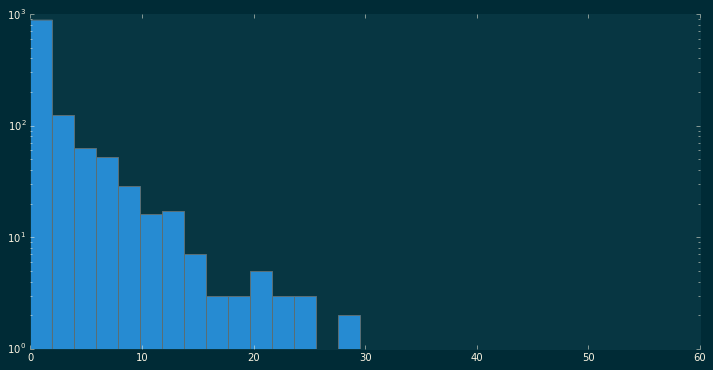

In [296]:
_ = plt.hist(avg_recipe.values(), bins = 30, log=True)

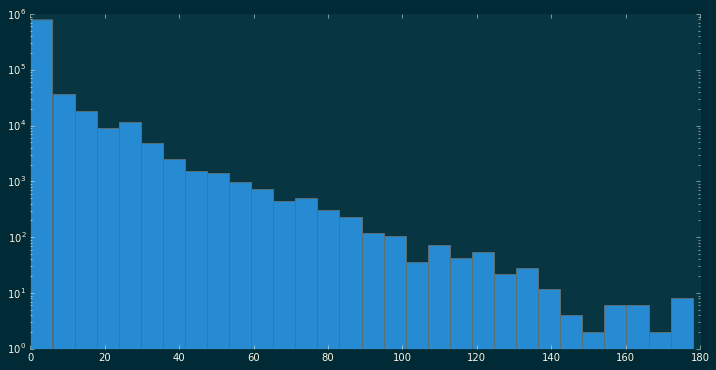

In [297]:
_ = plt.hist(avg_random.values(), bins = 30, log=True)

In [13]:
avg_random.keys()[:5]

[u'half and half, mango syrup',
 u'star anise, edible pansy',
 u'grenadine, evaporated milk',
 u'tamarind, vanilla cognac',
 u'honey, chardonnay']

In [57]:
rand_weights = pd.Series(avg_random.values())
rand_keys = pd.Series(avg_random.keys())
bin_indices = pd.cut(rand_weights, 180)

In [58]:
bin_indices[:5]

0     (-0.178, 0.989]
1     (-0.178, 0.989]
2     (-0.178, 0.989]
3    (19.778, 20.767]
4     (-0.178, 0.989]
dtype: category
Categories (180, object): [(-0.178, 0.989] < (0.989, 1.978] < (1.978, 2.967] < (2.967, 3.956] ... (174.0444, 175.0333] < (175.0333, 176.0222] < (176.0222, 177.0111] < (177.0111, 178]]

In [55]:
ti1 = rand_keys[3]
ti1

u'tamarind, vanilla cognac'

In [106]:
bin_lookup = pd.concat([rand_keys, bin_indices], axis =1 )
bin_lookup.columns =['pair', 'bin']
bin_lookup = bin_lookup.set_index('pair')
# bin_lookup

In [117]:
bin_dict = bin_lookup['bin'].to_dict()

In [164]:
bin_dict

{u'half and half, mango syrup': '(-0.178, 0.989]',
 u'star anise, edible pansy': '(-0.178, 0.989]',
 u'grenadine, evaporated milk': '(-0.178, 0.989]',
 u'honey, chardonnay': '(-0.178, 0.989]',
 u'beer,, coconut water with tangerine': '(4.944, 5.933]',
 u'orange twist, sugar syrup': '(-0.178, 0.989]',
 u'amaro montenegro, tomato': '(3.956, 4.944]',
 u'scaldis p\xe3\xaache mel beer, cocoa powder': '(10.878, 11.867]',
 u'chocolate milk, cardamaro amaro': '(-0.178, 0.989]',
 u'kiwi, bittermen\u2019s mol\xe9 bitters': '(10.878, 11.867]',
 u'tangerine juice, thai basil': '(-0.178, 0.989]',
 u'shelled raw pistachios, peach shrub': '(-0.178, 0.989]',
 u'pickled peppers, strawberrry-infused aperol': '(6.922, 7.911]',
 u'pumpkin beer, a\xe7a\xed sugar': '(4.944, 5.933]',
 u"regan's orange bitters no. 6, baileys with a hint of caramel": '(-0.178, 0.989]',
 u'purely syrup grapefruit, ancho chile powder': '(-0.178, 0.989]',
 u'hibiscus-rosehip tea, tamarind': '(-0.178, 0.989]',
 u'strawberry syrup,

In [144]:
def null_fractions(pair_list):
    in_rec = defaultdict(int)
    tot_numb_in_bin = defaultdict(int)
    for pair in pair_list:
        ingrds = pair.split(', ')
        pair_id = ingrds[0] + ', ' + ingrds[1]
        for recipe in comb_rec.values():
            if ingrds[0] in recipe and ingrds[1] in recipe:
                in_rec[bin_dict[pair_id]] += 1
            tot_numb_in_bin[bin_dict[pair_id]] += 1
        fractions = {k: float(in_rec[k])/tot_numb_in_bin[k] for k in tot_numb_in_bin}
    return fractions

In [135]:
len(rand_keys)/2000/60

7.293

In [148]:
%prun bin_fracts= null_fractions(rand_keys)

In [407]:
with open('bin_fracts.pkl', 'w') as f:
    pickle.dump(bin_fracts, f)

In [190]:
def compute_bin_center(bin_id):    
    b_center = bin_id.split('(')[1].split(', ')
    b_center = ((float(b_center[0]) + float(b_center[1].split(']')[0])))/2
    return b_center

In [288]:
bd = {compute_bin_center(k):v for k,v in bin_fracts.iteritems()}
ordered_bins = sorted(bd.items(), key=lambda t: t[0])

ordered_bins= [(ob[0], ob[1]/0.0001) for ob in ordered_bins if ob[1]>0]

In [337]:
xns = [i[0] for i in ordered_bins][:70]
yb = [i[1] for i in ordered_bins][:70]

lin_reg = OLS(np.array(yb).reshape(-1,1), np.array(xns).reshape(-1,1))
results = lin_reg.fit()
results.summary()

In [351]:
lin_mod = LinearRegression()
lin_mod.fit(np.array(xns).reshape(-1,1), np.array(yb))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

NameError: name 'b16_colors' is not defined

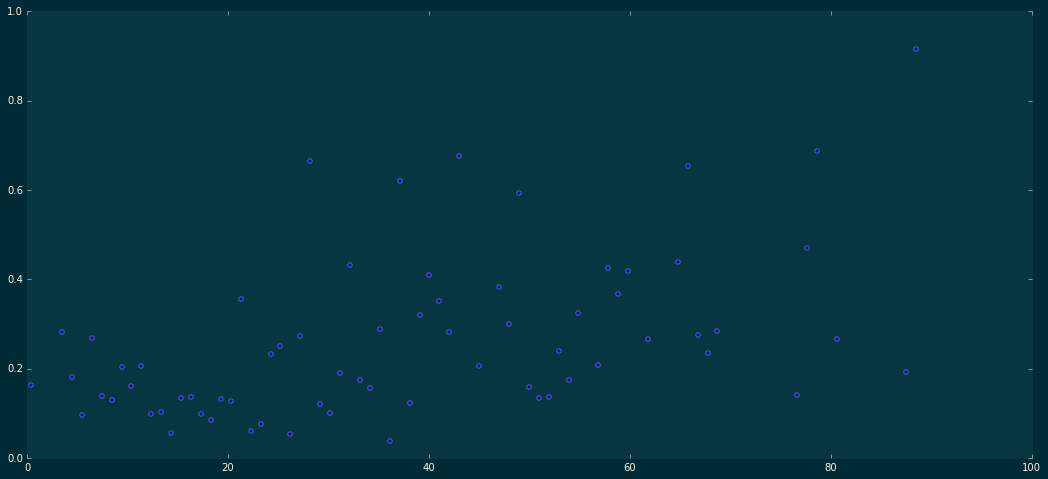

In [381]:
plt.scatter(xns, yb)
plt.xlim((0,100))
plt.ylim((0, 1))
plt.plot(xns, lin_mod.predict(np.array(xns).reshape(-1,1)), color=b16_colors.r,alpha=0.9, linewidth=5.0)
plt.title('Ingredient Coocurrences', fontsize=50, verticalalignment='bottom')
plt.ylabel("Fraction of pairs extant", fontsize=30, labelpad=15)
plt.xlabel("Number of shared flavor compounds", fontsize=30, labelpad=10)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)